# Exploratory Data Analysis
Presents descriptive statistics for the public domain data set.

    Copyright (C) 2021 Geoffrey Guy Messier

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https://www.gnu.org/licenses/>.

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import numpy as np
import pandas as pd
import datetime, copy, imp
import time
import os
import re
import matplotlib.pyplot as plt


from tqdm.auto import tqdm, trange
from tqdm.notebook import tqdm
tqdm.pandas()

import sys
sys.path.insert(0, '../util/')

In [3]:
dataFileStr = '../data/MLBHospitalData.hd5'
dat = pd.read_hdf(dataFileStr,key='Data')

The data is stored as a multi-index pandas table. The first index level is a hash of the individual's first and last name (ie. 'abrej003') and the second level is a numerical index of all the events linked to the record of that individual.

In [4]:
dat

Date           Event
Player                                          
abrej003 0   2009-01-08 00:01:00  GoodTestResult
         1   2009-06-03 00:01:00            Stay
         2   2009-06-05 00:01:00            Stay
         3   2009-06-06 00:01:00            Stay
         4   2009-06-07 00:01:00            Stay
...                          ...             ...
zunim001 718 2014-10-26 00:01:00            Stay
         719 2014-10-29 00:01:00            Stay
         720 2014-11-05 00:01:00            Stay
         721 2014-11-12 00:01:00            Stay
         722 2015-12-11 00:01:00  GoodTestResult

[452995 rows x 2 columns]

The columns of our table are Date and a categorical Event field that indicates the type of event.  The values of Event are:

In [5]:
dat.Event.unique()

array(['GoodTestResult', 'Stay', 'BadTestResult', 'VitalsCrash'],
      dtype=object)

- `GoodTestResult`: A medical test that comes back with good results.
- `BadTestResult`: A medical test that comes back with bad results.
- `VitalsCrash`: A very bad event where the individuals vitals crash (ie. a heart attack) and emergency medical aid is required.
- `Stay`: A 24 hour stay in hospital.

## Population Description
- Includes individuals who are right censored.

In [6]:
n = len(dat.index.get_level_values(0).unique())
print('Population: {} individuals'.format(n))

Population: 915 individuals


<AxesSubplot:>

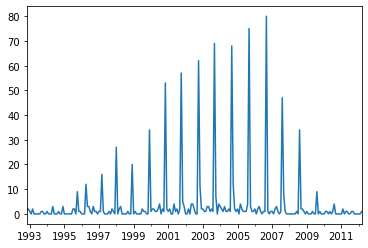

In [7]:
entryDates = dat.groupby(level=0).apply(lambda x: x.Date.min())
entryDateCount = pd.Series(range(n),index=entryDates).resample('1M').count()
entryDateCount.plot()
#plt.savefig('SystemEntry.eps')

In [8]:
# Count the data features for each individual.
def timeline_summary(tbl,startDate='NoDate',endDate='NoDate'):
    if startDate != 'NoDate' and endDate != 'NoDate':
        tbl = tbl.loc[ (tbl.Date >= startDate) & (tbl.Date <= endDate) ]
        
    return pd.Series({
        'NumGoodTestResult': (tbl.Event == 'GoodTestResult').sum(),
        'NumStay': (tbl.Event == 'Stay').sum(),
        'NumBadTestResult': (tbl.Event == 'BadTestResult').sum(),
        'NumVitalsCrash': (tbl.Event == 'VitalsCrash').sum(),
        'Tenure': (tbl.Date.max()-tbl.Date.min()).days
    })

In [9]:
ftr = dat.groupby(level=0).progress_apply(timeline_summary)

  0%|          | 0/915 [00:00<?, ?it/s]

In [10]:
ftr

,NumGoodTestResult,NumStay,NumBadTestResult,NumVitalsCrash,Tenure
Player,,,,,
abrej003,3,899,179,5,2180
ackld001,9,556,46,0,3502
adamc001,10,64,2,0,4709
adaml001,17,15,7,0,4100
adamm002,12,548,116,0,4040
...,...,...,...,...,...
zimmb001,2,104,10,0,2991
zimmj003,4,273,1,0,4803
zimmr001,4,1618,270,4,5500


Histograms are a very common way to get an idea of what a data feature is like.  However, the mean/median values and tail properties are sometimes hard to see for exponentially distributed data.

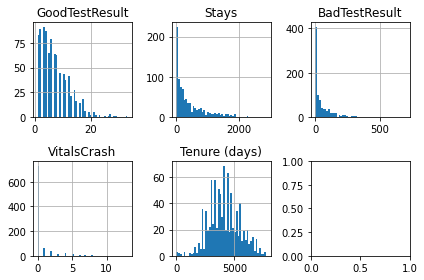

In [11]:
fg,((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3)

ftr.NumGoodTestResult.hist(bins=50,ax=ax1)
ax1.set_title('GoodTestResult')

ftr.NumStay.hist(bins=50,ax=ax2)
ax2.set_title('Stays')

ftr.NumBadTestResult.hist(bins=50,ax=ax3)
ax3.set_title('BadTestResult')

ftr.NumVitalsCrash.hist(bins=50,ax=ax4)
ax4.set_title('VitalsCrash')

ftr.Tenure.hist(bins=50,ax=ax5)
ax5.set_title('Tenure (days)')

fg.tight_layout()
#plt.savefig('Histograms.eps')

Boxplots illustrate median and quartile values a bit more explicitly.  Quartile values can also give us an idea of how symetric the distribution is.

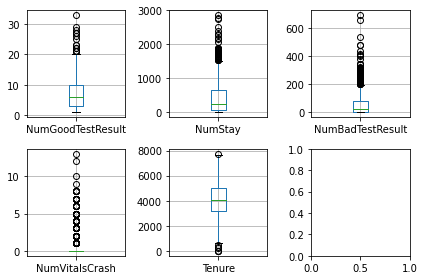

In [12]:
fg,((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3)

ftr.boxplot(column = [ 'NumGoodTestResult'], ax=ax1)
ftr.boxplot(column = [ 'NumStay'], ax=ax2)
ftr.boxplot(column = [ 'NumBadTestResult'], ax=ax3)
ftr.boxplot(column = [ 'NumVitalsCrash'], ax=ax4)
ftr.boxplot(column = [ 'Tenure'], ax=ax5)

fg.tight_layout()
#fg.savefig('Boxplots.eps')

## Constrain Data
For many studies, it's necessary to constrain generic time series data into *observation intervals* and *follow up intervals*.  This is commonly done for the survival analysis that is popular for medical studies.  The general idea is that we summarize the input data features from the observation interval (these are also known as *covariates*) and use those input features to predict whether the adverse outcome occurs in the follow up interval.  The adverse outcome is also known as our *outcome variable*.

**NOTE:** This type of windowing is NOT the only or even the best way to pre-process data when predicting an adverse outcome.  It's just a simple way to start.

In [13]:
# Observation inteval.
obsStart = pd.to_datetime('2002-01-01')
obsEnd = pd.to_datetime('2004-12-31')

# Follow up interval.
followStart = pd.to_datetime('2004-01-01')
followEnd = pd.to_datetime('2006-12-31')

Identify whether a vitals crash occurs.  If it does, also determine the time it took to occur.  This information is known as *time to event (TTE)*.

In [14]:
def find_vitals_crash(tbl,startDate,endDate):
    advOutIdx = (tbl.Event == 'VitalsCrash') & (tbl.Date >= startDate) & (tbl.Date <= endDate)
    if advOutIdx.sum() > 0:
        return pd.Series({
            'Flag': 'Crash',
            'Time': (tbl.loc[advOutIdx].Date.min() - startDate).days
        })
    else:
        return pd.Series({
            'Flag': 'NoCrash',
            'Time': max(0,(endDate - startDate).days)
        })

In [15]:
tte = dat.groupby(level=0).progress_apply(find_vitals_crash,startDate=followStart,endDate=followEnd)

  0%|          | 0/915 [00:00<?, ?it/s]

In [16]:
tte

,Flag,Time
Player,,
abrej003,NoCrash,1095
ackld001,NoCrash,1095
adamc001,NoCrash,1095
adaml001,NoCrash,1095
adamm002,NoCrash,1095
...,...,...
zimmb001,NoCrash,1095
zimmj003,NoCrash,1095
zimmr001,Crash,376


Find covariates by summing the number of events over the study period.

In [17]:
ftrObs = dat.groupby(level=0).progress_apply(timeline_summary,startDate=obsStart,endDate=obsEnd)

  0%|          | 0/915 [00:00<?, ?it/s]

In [18]:
ftrObs['Flag'] = tte.Flag

The following boxplots indicate a clear difference between the data features for the `Crash` and `NoCrash` individuals.  This suggests that they will be useful when predicting adverse outcomes.

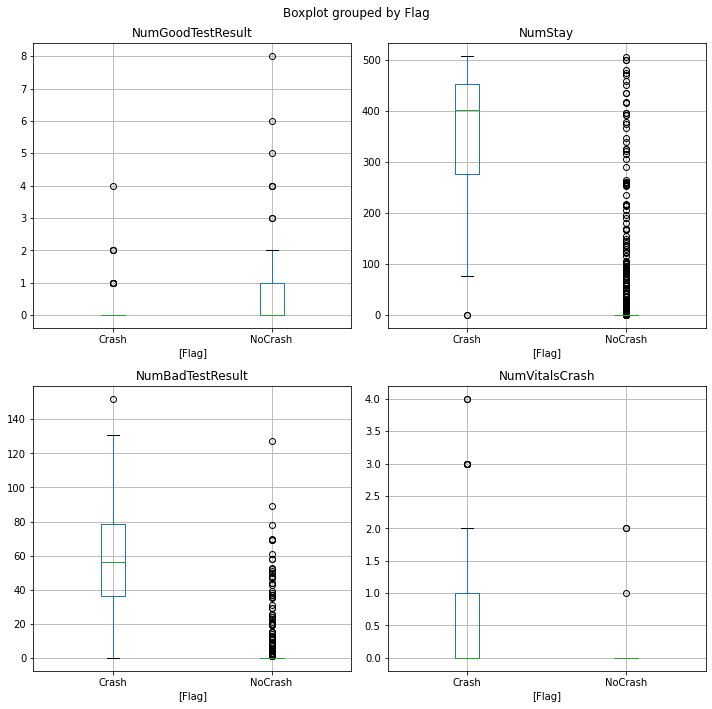

In [19]:
fg,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,10))

ftrObs.boxplot(column = [ 'NumGoodTestResult'], by=['Flag'], ax=ax1)
ftrObs.boxplot(column = [ 'NumStay'], by=['Flag'], ax=ax2)
ftrObs.boxplot(column = [ 'NumBadTestResult'], by=['Flag'], ax=ax3)
ftrObs.boxplot(column = [ 'NumVitalsCrash'], by=['Flag'], ax=ax4)

fg.tight_layout()
#fg.savefig('OutcomeBoxplots.eps')

Scatter plots allow us to see both the effect of data features on our outcome variable and on each other.  When two data features are very correlated, many machine learning algorithms will discard one of them since having both does not improve performance. 

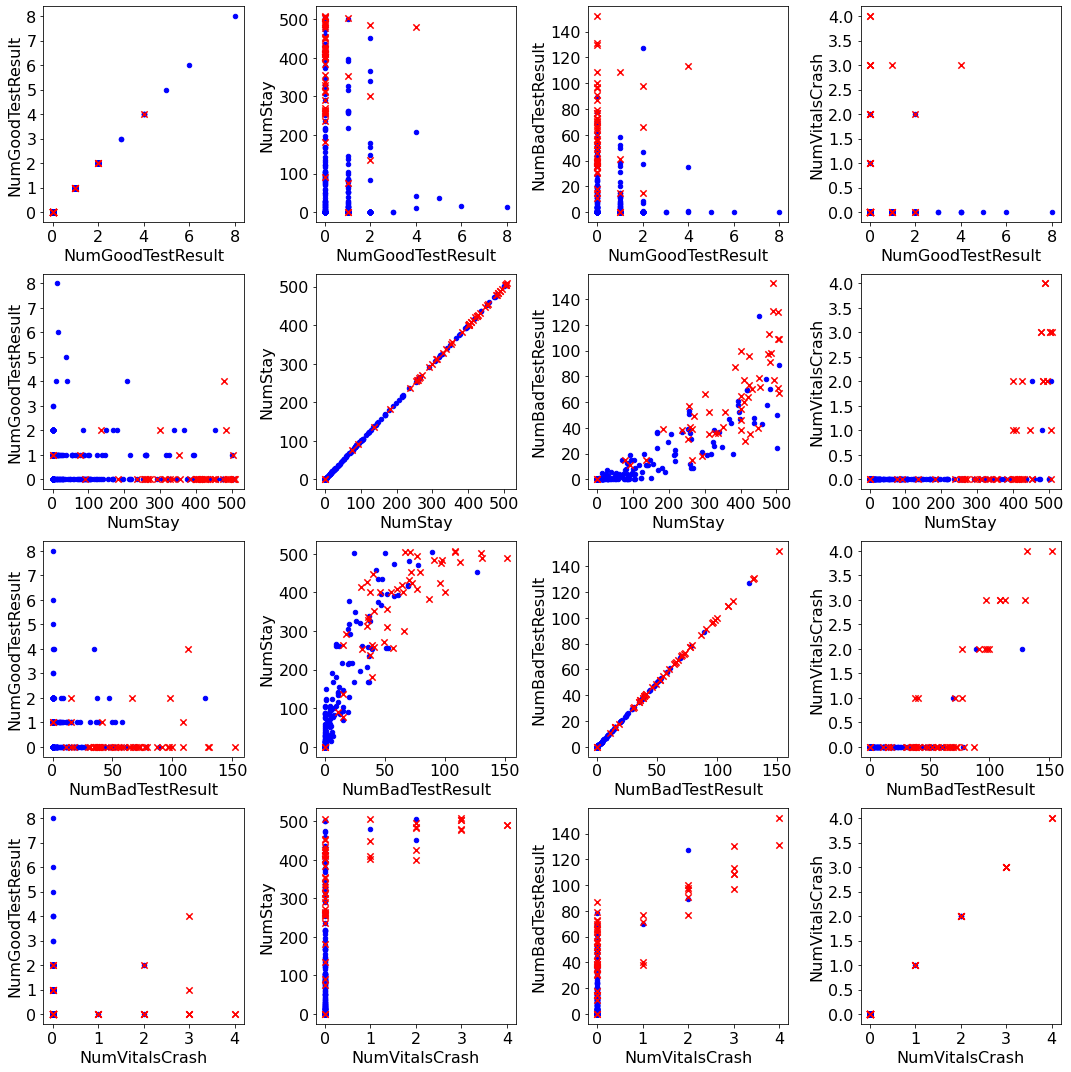

In [20]:
def PlotScatter(xStr,yStr,axis):
    axis.xaxis.label.set_size(16)
    axis.yaxis.label.set_size(16)
    ftrObs.loc[iNAdv].plot.scatter(x=xStr,y=yStr,c='blue',marker='o',ax=axis,fontsize=16)
    ftrObs.loc[iAdv].plot.scatter(x=xStr,y=yStr,c='red',marker='x',s=40,ax=axis,fontsize=16)

fg,axs = plt.subplots(4,4,figsize=(15,15))
iAdv = ftrObs.Flag == 'Crash'
iNAdv = ftrObs.Flag == 'NoCrash'

colNames = ftrObs.columns
nCols = len(colNames)-2

for iX in range(nCols):
    for iY in range(nCols):
        PlotScatter(colNames[iX],colNames[iY],axs[iX,iY])

fg.tight_layout()
#fg.savefig('Scatter.eps')

This just prints out one row of the scatterplot matrix (easier for importing into a presentation).

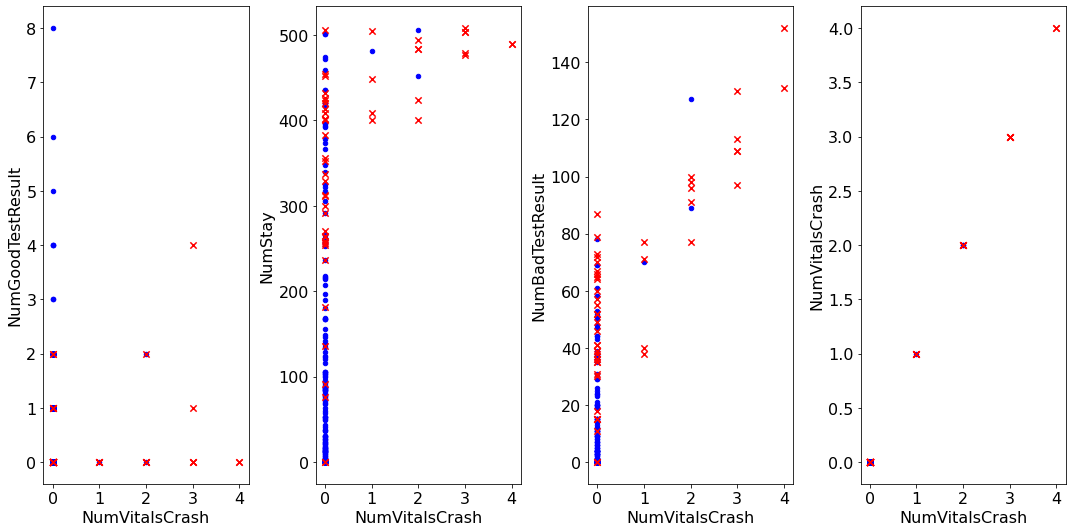

In [21]:
fg,axs = plt.subplots(1,4,figsize=(15,7.5))
iX = 3
for iY in range(nCols):
    PlotScatter(colNames[iX],colNames[iY],axs[iY])

fg.tight_layout()
#fg.savefig('Scatter{}.eps'.format(iX))